In [30]:
import math
import sys
from typing import Iterator, Tuple
sys.path.append('../')

import hydra
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F

from models import ACTIVATION_MAP, ParallelLinear
from run_experiment import standardize_targets
from tasks import NonlinearGEOFFTask

%matplotlib inline

In [2]:
hydra.initialize(config_path='../conf')

/tmp/ipykernel_97572/1376431350.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


hydra.initialize()

In [4]:
def standardize_targets(
    targets: torch.Tensor,
    cumulant_mean: float,
    cumulant_square_mean: float,
    cumulant_gamma: float,
    step: int,
) -> torch.Tensor:
    """Standardize targets using a running mean and variance."""
    cumulant_mean = cumulant_gamma * cumulant_mean + (1 - cumulant_gamma) * targets.mean()
    cumulant_square_mean = cumulant_gamma * cumulant_square_mean + (1 - cumulant_gamma) * targets.square().mean()
    bias_correction = 1 / (1 - cumulant_gamma ** (step + 1))
    curr_mean = cumulant_mean * bias_correction
    curr_square_mean = cumulant_square_mean * bias_correction
    std_dev = torch.max(torch.tensor(0.0), curr_square_mean - curr_mean.square()).sqrt()
    std_dev = 1 if std_dev < 1e-6 else std_dev
    targets = (targets - curr_mean) / std_dev
    return targets, cumulant_mean, cumulant_square_mean

In [41]:
class ZeroMaskedGradients(torch.autograd.Function):
    """Custom autograd function to zero out gradients for masked weights."""
    
    @staticmethod
    def forward(ctx, weights: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        ctx.save_for_backward(mask)
        return weights

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None]:
        mask, = ctx.saved_tensors
        return grad_output * mask, None


class ParallelLinear(nn.Module):
    """A linear layer that applies multiple weight matrices in parallel to the same input.
    
    Args:
        in_features: Size of each input sample
        out_features: Size of each output sample
        n_parallel: Number of parallel weight matrices
        bias: If True, adds a learnable bias to the output
    """
    
    def __init__(
        self,
        in_features: int,
        out_features: int,
        n_parallel: int,
        bias: bool = True,
        sparsity: float = 0,
    ) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_parallel = n_parallel
        self.sparsity = sparsity
        
        self.weight = nn.Parameter(torch.empty(n_parallel, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(n_parallel, out_features))
        else:
            self.register_parameter('bias', None)
        
        if self.sparsity > 0:
            sparsity_mask = (torch.rand_like(self.weight) > sparsity).float()
            self.register_buffer('sparsity_mask', sparsity_mask)
            self.weight = self.weight * self.sparsity_mask
            
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        """Initialize weights using the same strategy as nn.Linear."""
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in = self.weight.size(1)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (in_features,) or (n_parallel, in_features)
            
        Returns:
            Output tensor of shape (n_parallel, out_features)
        """
        # Reshape input to (n_parallel, in_features, 1)
        if x.dim() == 1:
            x = x.unsqueeze(0).unsqueeze(2).expand(self.n_parallel, -1, 1)
        elif x.dim() == 2:
            x = x.unsqueeze(2)
        else:
            raise ValueError(f'Input tensor must have 1 or 2 dimensions, got {x.dim()}')
        
        if self.sparsity > 0:
            weight = self.weight * self.sparsity_mask
            weight = ZeroMaskedGradients.apply(sparse_weight, self.sparsity_mask)
        else:
            weight = self.weight
        
        # Apply parallel matrix multiplication
        output = torch.bmm(weight, x)
        output = output.squeeze(2)
        
        if self.bias is not None:
            output += self.bias
        
        return output


class ParallelMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_parallel: int,
        n_layers: int,
        hidden_dim: int,
        activation: str = 'tanh',
        sparsity: float = 0,
    ) -> None:
        """A simplified MLP that uses parallel linear layers to get multiple outputs.
        
        Args:
            input_dim: Number of input features
            output_dim: Number of output features per parallel network
            n_parallel: Number of parallel networks
            n_layers: Number of layers (including output)
            hidden_dim: Size of hidden layers
            activation: Activation function ('relu', 'tanh', or 'sigmoid')
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_parallel = n_parallel
        activation_cls = ACTIVATION_MAP[activation]
        
        # Build layers
        self.layers = nn.ModuleList()
        if n_layers == 1:
            self.layers.append(ParallelLinear(input_dim, output_dim, n_parallel, bias=False))
        else:
            self.layers.append(ParallelLinear(input_dim, hidden_dim, n_parallel, bias=False))
            self.layers.append(activation_cls())
            self.layers.append(nn.LayerNorm(hidden_dim))
            for _ in range(n_layers - 2):
                self.layers.append(ParallelLinear(hidden_dim, hidden_dim, n_parallel, bias=False))
                self.layers.append(activation_cls())
                self.layers.append(nn.LayerNorm(hidden_dim))
            self.layers.append(ParallelLinear(hidden_dim, output_dim, n_parallel, bias=False))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (input_dim,)
            
        Returns:
            Output tensor of shape (n_parallel, output_dim)
        """
        param_inputs = {}
        for i in range(0, len(self.layers) - 2, 3):
            param_inputs[self.layers[i].weight] = x
            x = self.layers[i](x) # Linear layer
            x = self.layers[i + 1](x) # Activation
            x = self.layers[i + 2](x) # Layer norm

        param_inputs[self.layers[-1].weight] = x
        return self.layers[-1](x), param_inputs


In [175]:
def center_gram(K):
    """Center a Gram matrix."""
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    return H @ K @ H

def linear_cka(X, Y):
    """Compute Linear CKA similarity between two sets of feature matrices."""
    K = X @ X.T
    L = Y @ Y.T
    K_centered = center_gram(K)
    L_centered = center_gram(L)

    numerator = np.sum(K_centered * L_centered)
    denominator = np.sqrt(np.sum(K_centered**2) * np.sum(L_centered**2))
    return numerator / (denominator + 1e-10)  # Avoid division by zero

def rbf_kernel(X, sigma=None):
    """Compute RBF kernel for a set of vectors."""
    sq_dists = np.sum(X**2, axis=1, keepdims=True) - 2 * X @ X.T + np.sum(X**2, axis=1)
    if sigma is None:
        sigma = np.sqrt(np.median(sq_dists) / 2)
    return np.exp(-sq_dists / (2 * sigma**2))

def rbf_cka(X, Y, sigma=None):
    """Compute RBF Kernel CKA similarity between two sets of feature matrices."""
    K = rbf_kernel(X, sigma)
    L = rbf_kernel(Y, sigma)
    K_centered = center_gram(K)
    L_centered = center_gram(L)

    numerator = np.sum(K_centered * L_centered)
    denominator = np.sqrt(np.sum(K_centered**2) * np.sum(L_centered**2))
    return numerator / (denominator + 1e-10)  # Avoid division by zero

def pairwise_cka_matrix(features, kernel='linear', sigma=None):
    """
    Compute a pairwise CKA matrix for feature representations across samples.
    
    Args:
        features (np.ndarray): Array of shape (n_samples, n_vectors, vector_dim).
        kernel (str): 'linear' for Linear CKA, 'rbf' for RBF Kernel CKA.
        sigma (float): Bandwidth for RBF kernel (optional).
    
    Returns:
        np.ndarray: Pairwise CKA matrix of shape (n_vectors, n_vectors).
    """
    n_vectors = features.shape[1]
    cka_matrix = np.zeros((n_vectors, n_vectors))

    for i in range(n_vectors):
        for j in range(i, n_vectors):
            X = features[:, i, :]  # Shape: (n_samples, vector_dim)
            Y = features[:, j, :]  # Shape: (n_samples, vector_dim)

            if kernel == 'linear':
                cka_value = linear_cka(X, Y)
            elif kernel == 'rbf':
                cka_value = rbf_cka(X, Y, sigma)
            else:
                raise ValueError("Invalid kernel type. Use 'linear' or 'rbf'.")
            
            cka_matrix[i, j] = cka_value
            cka_matrix[j, i] = cka_value  # Symmetric matrix

    return cka_matrix

In [176]:
def train_model(
    model: torch.nn.Module,
    task_iterator: Iterator,
    optimizer: torch.optim.Optimizer,
    n_steps: int,
    device: str,
    standardize_cumulants: bool = False,
    output_mean: float = 0.0,
    output_std: float = 1.0,
) -> tuple[np.ndarray, list, float, float]:
    """Trains model for specified number of steps and returns training history.
    
    Args:
        model: Neural network model to train
        task_iterator: Iterator yielding training data
        optimizer: Optimizer for model parameters
        n_steps: Number of training steps
        device: Device to run model on
        standardize_cumulants: Whether to standardize targets
        cumulant_mean: Running mean for standardization
        cumulant_square_mean: Running square mean for standardization 
        cumulant_gamma: Decay factor for running means
        
    Returns:
        Tuple containing:
        - Array of loss history
        - List of target history
        - Final cumulant mean
        - Final cumulant square mean
    """
    loss_history = []
    target_history = []

    for step in range(n_steps):
        # Generate batch of data
        inputs, targets = next(task_iterator)
        inputs, targets = inputs.to(device), targets.to(device)

        features = inputs.squeeze(0)
        
        if standardize_cumulants:
            targets = (targets - output_mean) / output_std
        target_history.append(targets.cpu().detach().numpy())

        # Forward pass
        outputs, param_inputs = model(features)
        outputs = outputs.squeeze(1)
        losses = (outputs - targets.squeeze()).pow(2)
        loss = losses.sum()
        loss_history.append(losses.cpu().detach().numpy())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_history = np.stack(loss_history, axis=1)
    return loss_history, target_history


def plot_loss_percentiles(loss_history: np.ndarray) -> None:
    """Plot loss curves for different percentiles of performance.
    
    Creates two plots showing the binned loss curves for different percentiles:
    1. With default y-axis limits
    2. With y-axis limits between 0 and 1
    
    Args:
        loss_history: Array of shape (n_samples, n_steps) containing loss values
    """
    # Get indices sorted by average loss
    avg_losses = loss_history.mean(axis=1)
    sorted_indices = np.argsort(avg_losses)

    # Extract indices at different percentiles 
    n_samples = len(sorted_indices)
    best_idx = sorted_indices[0]
    p10_idx = sorted_indices[int(0.1 * n_samples)]
    p25_idx = sorted_indices[int(0.25 * n_samples)]
    p50_idx = sorted_indices[int(0.5 * n_samples)]
    p75_idx = sorted_indices[int(0.75 * n_samples)]
    p90_idx = sorted_indices[int(0.9 * n_samples)]
    worst_idx = sorted_indices[-1]

    # Create 50 bins
    n_bins = 50
    bin_size = len(loss_history[0]) // n_bins
    x_points = np.arange(n_bins) * bin_size

    # Compute binned averages by reshaping and taking mean
    selected_losses = loss_history[[best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]]
    reshaped = selected_losses.reshape(7, n_bins, bin_size)
    binned_losses = reshaped.mean(axis=2)
    
    # Create color palette that transitions from blue to red
    colors = sns.color_palette('RdBu_r', n_colors=7)

    # Plot with default y limits
    plt.figure()
    sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
    sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
    sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
    sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
    sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
    sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
    sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
    plt.legend()
    plt.show()


In [177]:
config = hydra.compose(
    config_name = 'sparse_binary_geoff',
    overrides = [
        'device=cuda',
        
        # Task params
        'task.n_features=10',
        'task.hidden_dim=5',
        'task.sparsity=0.0',
        'task.n_layers=2',
        
        # Model params
        'model.output_dim=1',
        'model.n_layers=3',
        'model.hidden_dim=100',
        'model.activation=relu',
        '+model.n_parallel=50',
        '+model.sparsity=0.0',
        
        # Training params
        'train.learning_rate=0.0001',
        'train.weight_decay=0.0',
        'train.standardize_cumulants=True',
    ]
)

In [178]:
task = NonlinearGEOFFTask(
    n_features = config.task.n_features,
    flip_rate = config.task.flip_rate,
    n_layers = config.task.n_layers,
    n_stationary_layers = config.task.n_stationary_layers,
    hidden_dim = config.task.hidden_dim if config.task.n_layers > 1 else 0,
    weight_scale = config.task.weight_scale,
    activation = config.task.activation,
    sparsity = config.task.sparsity,
    weight_init = config.task.weight_init,
)

task_iterator = task.get_iterator(1)

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: -0.5144, output std: 1.0463


In [179]:
# Initialize model and optimizer
model = ParallelMLP(
    input_dim = config.task.n_features,
    output_dim = config.model.output_dim,
    n_parallel = config.model.n_parallel,
    n_layers = config.model.n_layers,
    hidden_dim = config.model.hidden_dim,
    activation = config.model.activation,
    sparsity = config.model.sparsity,
).to(config.device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

# Effectively RMSProp
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = config.train.learning_rate,
    betas = (0, 0.999),
    weight_decay = config.train.weight_decay,
)

Total parameters: 555,400


## CKA pre-training

In [192]:
n_samples = 200
device = config.device
representations = [] # (n_samples, n_parallel, n_features)

# Generate batch of feature samples
for i in range(n_samples):
    inputs = next(task_iterator)[0]
    features = inputs.squeeze(0).to(device)
    with torch.no_grad():
        outputs, param_inputs = model(features)
    representations.append(param_inputs[model.layers[-1].weight])

representations = torch.stack(representations, axis=0)
representations = representations.cpu().detach().numpy()

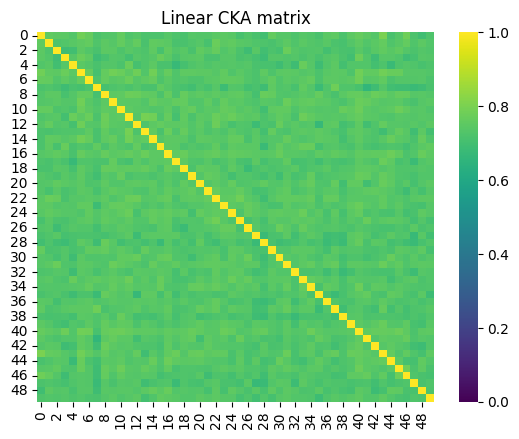

Mean Linear CKA: 0.7336


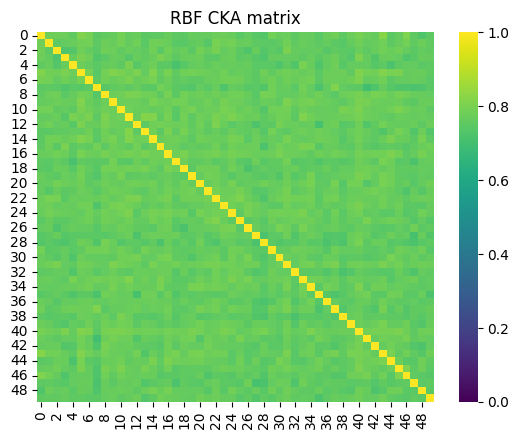

Mean RBF CKA: 0.7648


In [193]:
n_reprs = representations.shape[1]

# Compute Linear CKA matrix
linear_cka_matrix = pairwise_cka_matrix(representations, kernel='linear')
sns.heatmap(linear_cka_matrix, cmap='viridis', vmin=0, vmax=1)
plt.title('Linear CKA matrix')
plt.show()

mean_linear_cka = np.tril(linear_cka_matrix, k=-1).sum() / (n_reprs * (n_reprs - 1) / 2)
print(f'Mean Linear CKA: {mean_linear_cka:.4f}')

rbf_cka_matrix = pairwise_cka_matrix(representations, kernel='rbf')
sns.heatmap(rbf_cka_matrix, cmap='viridis', vmin=0, vmax=1)
plt.title('RBF CKA matrix')
plt.show()

mean_rbf_cka = np.tril(rbf_cka_matrix, k=-1).sum() / (n_reprs * (n_reprs - 1) / 2)
print(f'Mean RBF CKA: {mean_rbf_cka:.4f}')


In [128]:
phase_one_steps = 10000
phase_two_steps = 5000

frac_weight_change = 0.2

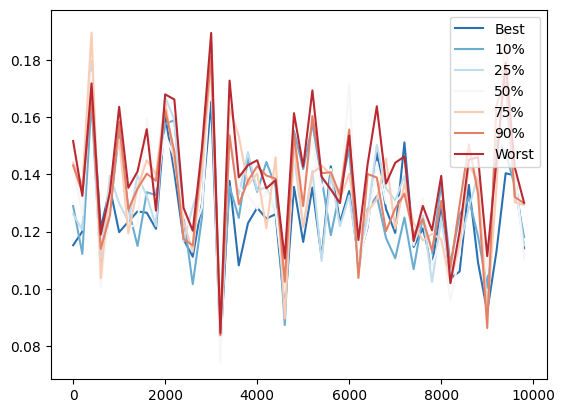

In [134]:
loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_one_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
plot_loss_percentiles(loss_history)

## CKA post-training

In [ ]:
n_samples = 200
device = config.device
representations = [] # (n_samples, n_parallel, n_features)

# Generate batch of feature samples
for i in range(n_samples):
    inputs = next(task_iterator)[0]
    features = inputs.squeeze(0).to(device)
    with torch.no_grad():
        outputs, param_inputs = model(features)
    representations.append(param_inputs[model.layers[-1].weight])

representations = torch.stack(representations, axis=0)
representations = representations.cpu().detach().numpy()

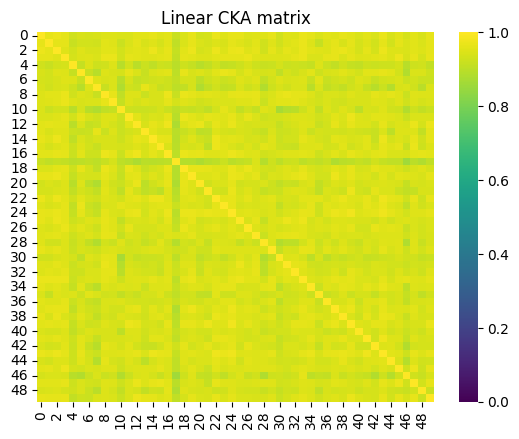

Mean Linear CKA: 0.9393


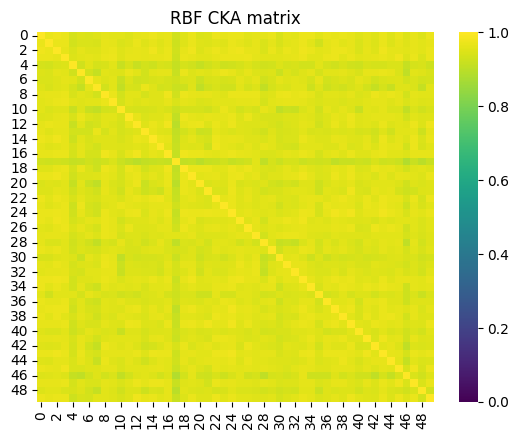

Mean RBF CKA: 0.9498


In [174]:
n_reprs = representations.shape[1]

# Compute Linear CKA matrix
linear_cka_matrix = pairwise_cka_matrix(representations, kernel='linear')
sns.heatmap(linear_cka_matrix, cmap='viridis', vmin=0, vmax=1)
plt.title('Linear CKA matrix')
plt.show()

mean_linear_cka = np.tril(linear_cka_matrix, k=-1).sum() / (n_reprs * (n_reprs - 1) / 2)
print(f'Mean Linear CKA: {mean_linear_cka:.4f}')

rbf_cka_matrix = pairwise_cka_matrix(representations, kernel='rbf')
sns.heatmap(rbf_cka_matrix, cmap='viridis', vmin=0, vmax=1)
plt.title('RBF CKA matrix')
plt.show()

mean_rbf_cka = np.tril(rbf_cka_matrix, k=-1).sum() / (n_reprs * (n_reprs - 1) / 2)
print(f'Mean RBF CKA: {mean_rbf_cka:.4f}')


In [121]:
# Get total number of weights
final_layer_weights = task.weights[-1]
n_weights = final_layer_weights.numel()

# Calculate number of weights to flip (20%)
n_flip = int(0.2 * n_weights)

# Get random indices to flip
flip_indices = torch.randperm(n_weights)[:n_flip]

orig_shape = task.weights[-1].shape
with torch.no_grad():
    task.weights[-1].view(-1)[flip_indices] *= -1

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: -1.5078, output std: 0.9272


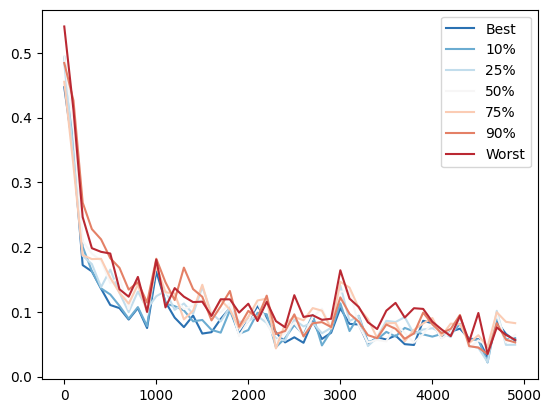

In [122]:
loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_two_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
plot_loss_percentiles(loss_history)

In [12]:
loss_history_2 = []
target_history_2 = []

for step in range(phase_two_steps):
    # Generate batch of data
    inputs, targets = next(task_iterator)
    inputs, targets = inputs.to(config.device), targets.to(config.device)

    features = inputs.squeeze(0)
    
    if config.train.standardize_cumulants:
        with torch.no_grad():
            targets, cumulant_mean, cumulant_square_mean = standardize_targets(
                targets, cumulant_mean, cumulant_square_mean, cumulant_gamma, step)
    target_history_2.append(targets.cpu().detach().numpy())
    
    if step < 100:
        continue

    # Forward pass
    outputs, param_inputs = model(features)
    outputs = outputs.squeeze(1)
    losses = (outputs - targets.squeeze()).pow(2)
    loss = losses.sum()
    loss_history_2.append(losses.cpu().detach().numpy())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()
    
loss_history_2 = np.stack(loss_history_2, axis=1)

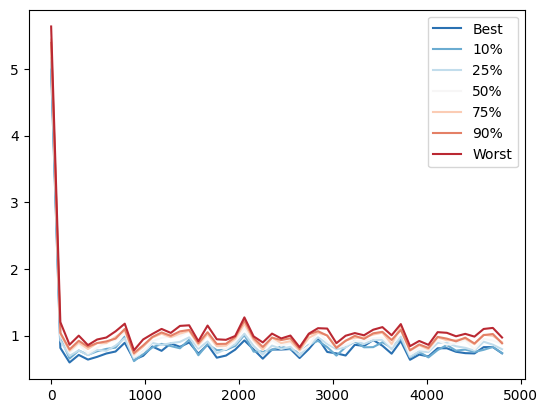

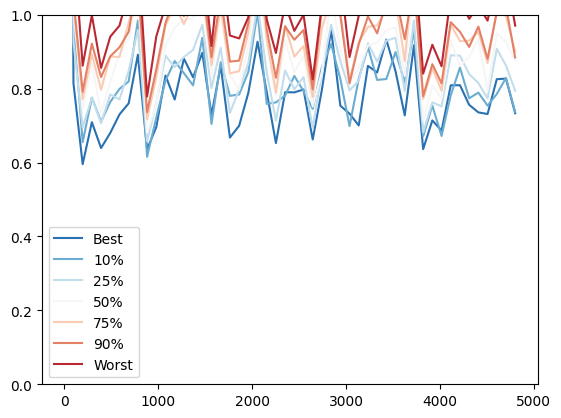

In [13]:
# Get indices sorted by average loss
avg_losses = loss_history_2.mean(axis=1)
sorted_indices = np.argsort(avg_losses)

# Extract indices at different percentiles
n_samples = len(sorted_indices)
best_idx = sorted_indices[0]
p10_idx = sorted_indices[int(0.1 * n_samples)]
p25_idx = sorted_indices[int(0.25 * n_samples)]
p50_idx = sorted_indices[int(0.5 * n_samples)]
p75_idx = sorted_indices[int(0.75 * n_samples)]
p90_idx = sorted_indices[int(0.9 * n_samples)]
worst_idx = sorted_indices[-1]

# Create 50 bins
n_bins = 50
bin_size = len(loss_history_2[0]) // n_bins
x_points = np.arange(n_bins) * bin_size

# Compute binned averages by reshaping and taking mean
selected_losses = loss_history_2[[best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]]
reshaped = selected_losses.reshape(7, n_bins, bin_size)
binned_losses = reshaped.mean(axis=2)
# Create color palette that transitions from blue to red
colors = sns.color_palette('RdBu_r', n_colors=7)

# Plot with default y limits
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.legend()
plt.show()

# Plot with y limits between 0 and 1
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.ylim(0, 1)
plt.legend()
plt.show()
